In [ ]:

#!pip install sqlalchemy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import sqlite3, pandas as pd
conn = sqlite3.connect('fiddle.db')
with open('dataset/data.sql','r') as f:
    conn.executescript(f.read())




In [28]:
df = pd.read_sql_query('SELECT * FROM transactions;', conn)
df.head()


transaction_time  transaction_amount
0  2021-01-16 00:05:54.000000               25.05
1  2021-01-07 20:53:04.000000              124.00
2  2021-01-18 22:55:37.000000               66.58
3  2021-01-21 00:36:57.000000                9.99
4  2021-01-19 06:31:10.000000               22.27

In [20]:
df.shape

(114, 2)

In [21]:

df['transaction_time'] = pd.to_datetime(df['transaction_time'])


df['date'] = df['transaction_time'].dt.date

daily = (
    df
    .groupby('date')['transaction_amount']
    .sum()
    .reset_index()
    .sort_values('date')
)
daily['rolling_3d_avg'] = daily['transaction_amount'].rolling(window=3).mean()
result = daily[daily['date'] == pd.to_datetime('2021-01-31').date()]
print(result)


          date  transaction_amount  rolling_3d_avg
30  2021-01-31               59.43          682.15


ADF Statistic: -10.3222
p-value: 0.0000
Critical Value (1%): -3.4896
Critical Value (5%): -2.8875
Critical Value (10%): -2.5806


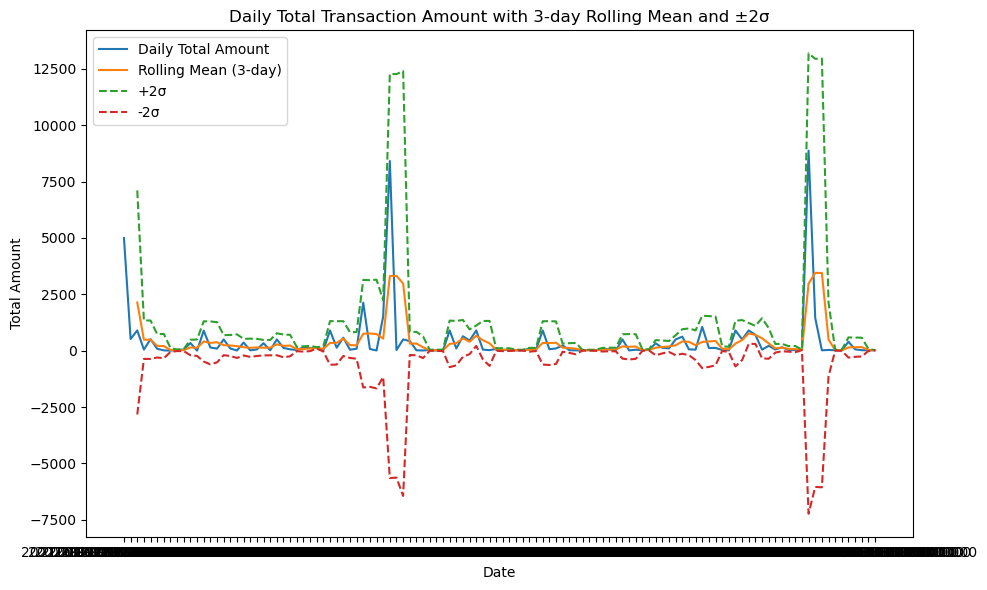

In [22]:
#fetching fresh copy again for time series plotting and dickey fuller test


df = pd.read_sql_query('SELECT transaction_time, transaction_amount FROM transactions', conn)
daily = df.groupby('transaction_time')['transaction_amount'].sum().sort_index()


adf_result = adfuller(daily)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
for key, val in adf_result[4].items():
    print(f'Critical Value ({key}): {val:.4f}')


rolling_mean = daily.rolling(window=3, center=False).mean()
rolling_std = daily.rolling(window=3, center=False).std()


plt.figure(figsize=(10, 6))
plt.plot(daily, label='Daily Total Amount')
plt.plot(rolling_mean, label='Rolling Mean (3-day)')
plt.plot(rolling_mean + 2*rolling_std, linestyle='--', label='+2σ')
plt.plot(rolling_mean - 2*rolling_std, linestyle='--', label='-2σ')
plt.title('Daily Total Transaction Amount with 3-day Rolling Mean and ±2σ')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ADF Statistic: -5.7767
p-value:        0.0000
Critical Value (1%): -3.6699
Critical Value (5%): -2.9641
Critical Value (10%): -2.6212


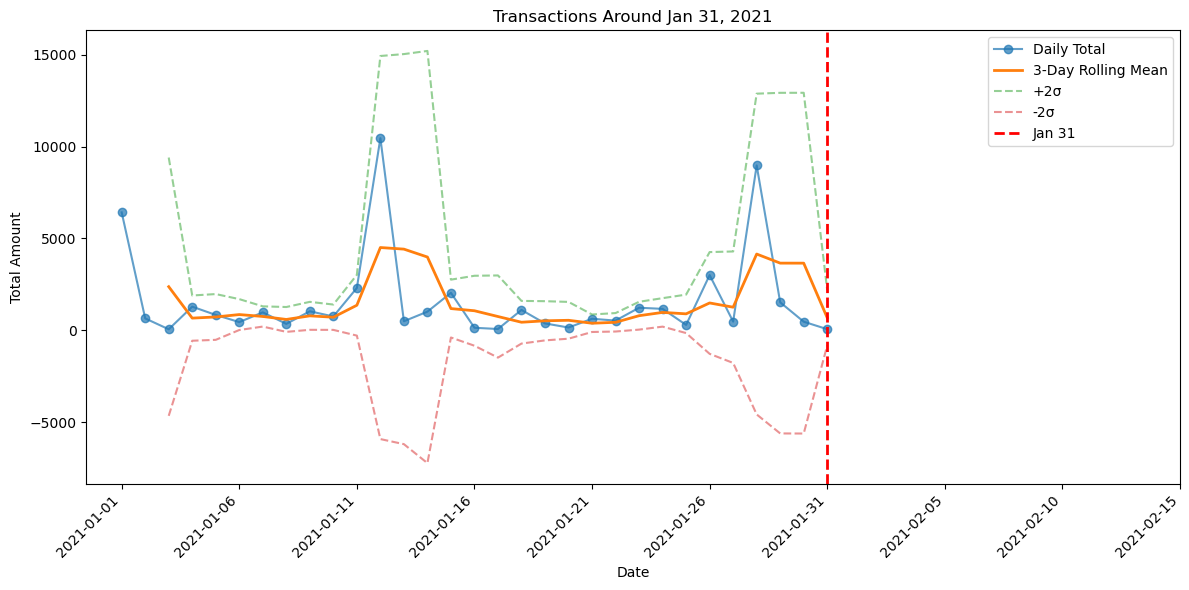

In [23]:



df = pd.read_sql_query(
    'SELECT transaction_time, transaction_amount FROM transactions',
    conn
)
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

daily = (
    df
    .set_index('transaction_time')
    .resample('D')['transaction_amount']
    .sum()
)

adf_result = adfuller(daily.fillna(0)) 
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value:        {adf_result[1]:.4f}')
for k, v in adf_result[4].items():
    print(f'Critical Value ({k}): {v:.4f}')

rolling_mean = daily.rolling(window=3).mean()
rolling_std  = daily.rolling(window=3).std()
focus = daily.loc['2021-01-01':'2021-02-15']

plt.figure(figsize=(12, 6))
plt.plot(focus.index, focus,
         marker='o', linestyle='-', alpha=0.7, label='Daily Total')
plt.plot(focus.index, rolling_mean.loc[focus.index],
         linewidth=2, label='3-Day Rolling Mean')
plt.plot(focus.index, (rolling_mean + 2*rolling_std).loc[focus.index],
         linestyle='--', alpha=0.5, label='+2σ')
plt.plot(focus.index, (rolling_mean - 2*rolling_std).loc[focus.index],
         linestyle='--', alpha=0.5, label='-2σ')

plt.axvline('2021-01-31', color='red',
            linestyle='--', linewidth=2, label='Jan 31')

plt.xticks(
    pd.date_range('2021-01-01', '2021-02-15', freq='5D'),
    rotation=45, ha='right'
)

plt.title('Transactions Around Jan 31, 2021')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.tight_layout()
plt.show()


Obviously that time series is a disaster. i can fix it, i'll write some suggestions on the README.

To be clear that time series also tries to print out 2 sigma + and 2 sigma - values.

Lets try some rudimentary decomposition.

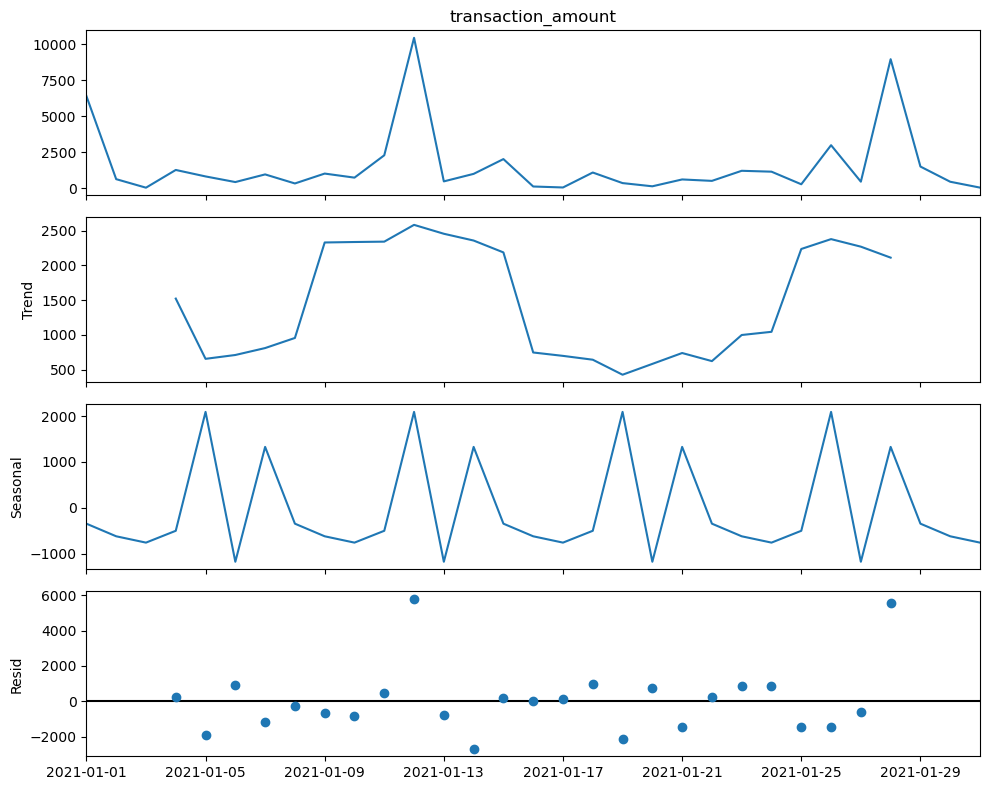

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(daily, model='additive', period=7)

fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


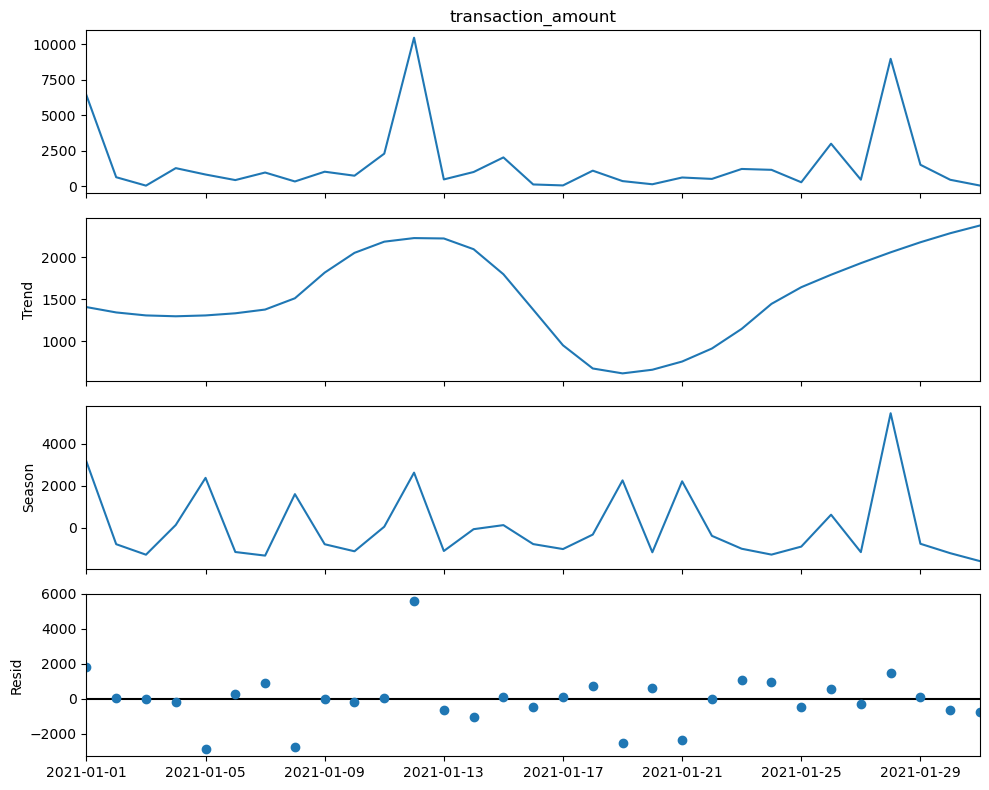

In [25]:
from statsmodels.tsa.seasonal import STL

stl = STL(daily, period=7)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


In [26]:
df = pd.read_sql_query('SELECT * FROM transactions;', conn) #refreshing df once again

In [27]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])


daily = (
    df
    .set_index('transaction_time')
    .resample('D')['transaction_amount']
    .sum()
    .reset_index()
)


daily['date'] = daily['transaction_time'].dt.date


start = pd.to_datetime('2021-01-29').date()
end   = pd.to_datetime('2021-01-31').date()
mask  = (daily['date'] >= start) & (daily['date'] <= end)
subset = daily.loc[mask, ['date','transaction_amount']] \
              .rename(columns={'transaction_amount':'transaction_sum'})


print(subset)


          date  transaction_sum
28  2021-01-29          1520.90
29  2021-01-30           466.12
30  2021-01-31            59.43
